# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import f_oneway
import joblib

# Loading Dataset

In [2]:
df = pd.read_csv("manufacturing_6G_dataset.csv")
target_col = 'Efficiency_Status'

# Label Encoding

In [3]:
df_encoded = df.copy()
le_target = LabelEncoder()
df_encoded[target_col] = le_target.fit_transform(df_encoded[target_col])

for col in df_encoded.select_dtypes(include='object').columns:
    if col != target_col and col != 'Timestamp':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

In [5]:
df.head()

,Timestamp,Machine_ID,Operation_Mode,Temperature_C,Vibration_Hz,Power_Consumption_kW,Network_Latency_ms,Packet_Loss_%,Quality_Control_Defect_Rate_%,Production_Speed_units_per_hr,Predictive_Maintenance_Score,Error_Rate_%,Efficiency_Status
0,2024-01-01 00:00:00,39,Idle,74.137590,3.500595,8.612162,10.650542,0.207764,7.751261,477.657391,0.344650,14.965470,Low
1,2024-01-01 00:01:00,29,Active,84.264558,3.355928,2.268559,29.111810,2.228464,4.989172,398.174747,0.769848,7.678270,Low
2,2024-01-01 00:02:00,15,Active,44.280102,2.079766,6.144105,18.357292,1.639416,0.456816,108.074959,0.987086,8.198391,Low
3,2024-01-01 00:03:00,43,Active,40.568502,0.298238,4.067825,29.153629,1.161021,4.582974,329.579410,0.983390,2.740847,Medium
4,2024-01-01 00:04:00,8,Idle,75.063817,0.345810,6.225737,34.029191,4.796520,2.287716,159.113525,0.573117,12.100686,Low


In [6]:
df_encoded.head()

,Timestamp,Machine_ID,Operation_Mode,Temperature_C,Vibration_Hz,Power_Consumption_kW,Network_Latency_ms,Packet_Loss_%,Quality_Control_Defect_Rate_%,Production_Speed_units_per_hr,Predictive_Maintenance_Score,Error_Rate_%,Efficiency_Status
0,2024-01-01 00:00:00,39,1,74.137590,3.500595,8.612162,10.650542,0.207764,7.751261,477.657391,0.344650,14.965470,1
1,2024-01-01 00:01:00,29,0,84.264558,3.355928,2.268559,29.111810,2.228464,4.989172,398.174747,0.769848,7.678270,1
2,2024-01-01 00:02:00,15,0,44.280102,2.079766,6.144105,18.357292,1.639416,0.456816,108.074959,0.987086,8.198391,1
3,2024-01-01 00:03:00,43,0,40.568502,0.298238,4.067825,29.153629,1.161021,4.582974,329.579410,0.983390,2.740847,2
4,2024-01-01 00:04:00,8,1,75.063817,0.345810,6.225737,34.029191,4.796520,2.287716,159.113525,0.573117,12.100686,1


# Feature Selection (RF + Anova)

In [7]:
# Feature Selection using RF

from sklearn.ensemble import RandomForestClassifier

X = df_encoded.drop([target_col, 'Timestamp'], axis=1)
y = df_encoded[target_col]

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fs, y_train_fs)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_n = 10
important_features = importances.head(top_n).index.tolist()
print(important_features)

['Error_Rate_%', 'Production_Speed_units_per_hr', 'Predictive_Maintenance_Score', 'Vibration_Hz', 'Power_Consumption_kW', 'Packet_Loss_%', 'Network_Latency_ms', 'Quality_Control_Defect_Rate_%', 'Temperature_C', 'Machine_ID']


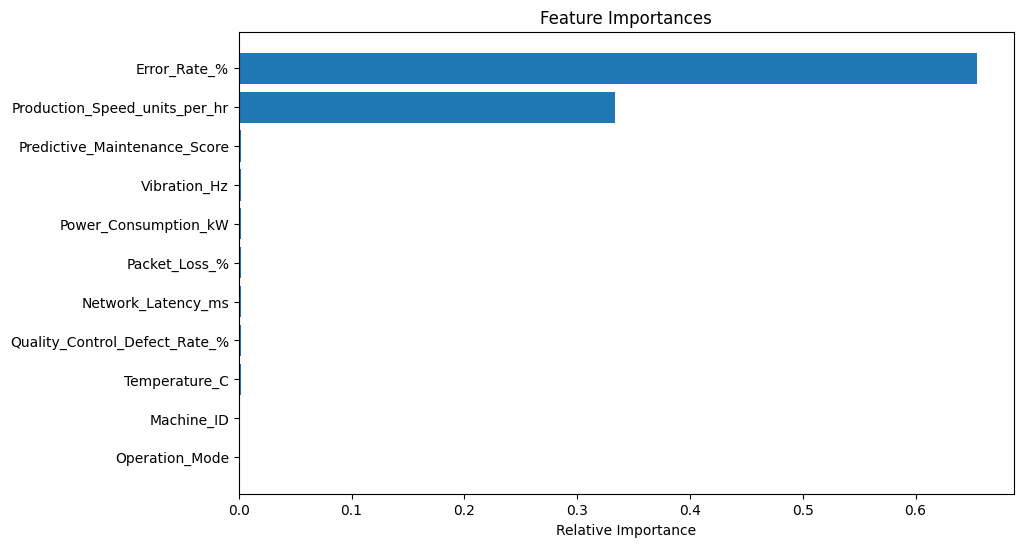

In [22]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [8]:
# Anova Test

numerical_cols = df.select_dtypes(include='number').columns.drop('Machine_ID', errors='ignore')
significant_anova_features = []
for col in numerical_cols:
    groups = [df[df[target_col] == cat][col] for cat in df[target_col].unique()]
    f_stat, p_value = f_oneway(*groups)
    if p_value < 0.05:
        significant_anova_features.append(col)

selected_features = list(set(important_features) & set(significant_anova_features))
print("\n✅ Selected Features:", selected_features)


✅ Selected Features: ['Production_Speed_units_per_hr', 'Error_Rate_%']


# Model Training

In [10]:
X_sel = df_encoded[selected_features]
y = df_encoded[target_col]
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

In [11]:
# Logistic Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

lr_params = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}

lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=3, n_jobs=-1, verbose=1)
lr_grid.fit(X_train, y_train)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'lr__C': [0.1, 1, ...], 'lr__penalty': ['l2'], 'lr__solver': ['lbfgs']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [12]:
lr_pred = lr_grid.predict(X_test)

In [13]:
# SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

svm_params = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01],
    'svm__kernel': ['rbf']
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=3, n_jobs=-1, verbose=1)
svm_grid.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,Pipeline(step...ility=True))])
,param_grid,"{'svm__C': [0.1, 1, ...], 'svm__gamma': ['scale', 0.01], 'svm__kernel': ['rbf']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [14]:
svm_pred = svm_grid.predict(X_test)

In [15]:
# # XGBoost
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# xgb_params = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5],
#     'learning_rate': [0.01, 0.1]
# }

# xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1, verbose=1)
# xgb_grid.fit(X_train, y_train)


In [16]:
# xgb_pred = xgb_grid.predict(X_test)

In [17]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

rf_grid = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'n_estimators': [100, 200]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [18]:
rf_pred = rf_grid.predict(X_test)

# Evaluation

In [19]:
print("\n📘 Logistic Regression Report:")
print(classification_report(y_test, lr_pred, target_names=le_target.classes_))

print("\n📗 SVM Report:")
print(classification_report(y_test, svm_pred, target_names=le_target.classes_))

# print("\n📕 XGBoost Report:")
# print(classification_report(y_test, xgb_pred, target_names=le_target.classes_))

print("\n📙 Random Forest Report:")
print(classification_report(y_test, rf_pred, target_names=le_target.classes_))


📘 Logistic Regression Report:
              precision    recall  f1-score   support

        High       0.91      0.81      0.86       625
         Low       0.94      0.96      0.95     15464
      Medium       0.80      0.77      0.78      3911

    accuracy                           0.92     20000
   macro avg       0.88      0.85      0.86     20000
weighted avg       0.91      0.92      0.92     20000


📗 SVM Report:
              precision    recall  f1-score   support

        High       0.98      0.98      0.98       625
         Low       1.00      1.00      1.00     15464
      Medium       0.99      0.99      0.99      3911

    accuracy                           1.00     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       1.00      1.00      1.00     20000


📙 Random Forest Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       625
         Low       1.00      1.00      1.00     15464
    

# Saving Models

In [20]:
joblib.dump(lr_grid.best_estimator_, 'logreg_best_model.pkl')
joblib.dump(svm_grid.best_estimator_, 'svm_best_model.pkl')
# joblib.dump(xgb_grid.best_estimator_, 'xgb_best_model.pkl')
joblib.dump(rf_grid.best_estimator_, 'rf_best_model.pkl')
joblib.dump(le_target, 'label_encoder.pkl')

['label_encoder.pkl']